In [1]:
from PIL import Image

# 0-a) preparation

## we use some python tools that may be dependent on some library versions. To avoid conflicts with other installed python libraries, I recommend you prepare anaconda
## $\circ$ let's make an environment for vamp_dpp

conda create -n vamp_dpp python=3.11 jupyter

## then activate the environment

# 0-b) installation of VAMP DPP and pyklip

## $\circ$VAMPIRES DPP (https://scexao-org.github.io/vampires_dpp/installation.html)
pip install -U git+https://github.com/scexao-org/vampires_dpp.git

## $\circ$pyklip (VAMPIRES class is not implemented yet in the original pyklip, so please install it via Miles' github; https://github.com/mileslucas/pyklip/tree/ml/vampires)
## you may also need to install git-lfs in advance to avoid errors (https://git-lfs.com/)

GIT_LFS_SKIP_SMUDGE=1 git clone git@github.com:mileslucas/pyklip pyklip-vampires  
cd pyklip-vampires  
git checkout ml/vampires  
pip install -e . 

# 0-c) what we want to do with the VAMPIRES data set?

## They're designated for AO-fed high angular-resolution/contrast imaging
### for high-contrast, we need post-processing (differential imaging) to subtract stellar PSF that hides faint disk/planet signals.

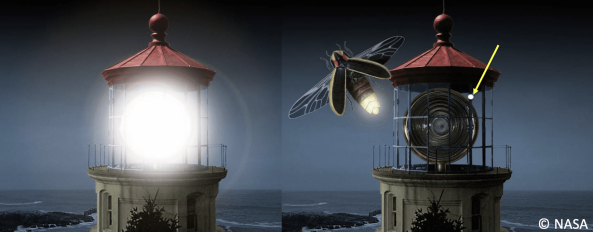

In [2]:
Image.open('figures_tutorial/lighthouse.png').reduce(3)

## the concept of differential imaging

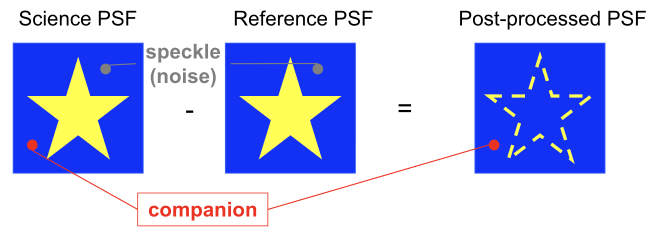

In [3]:
Image.open('figures_tutorial/differential_imaging.png').reduce(2)

## flowchart of high-contrast imaging

Image credit: C. Marois


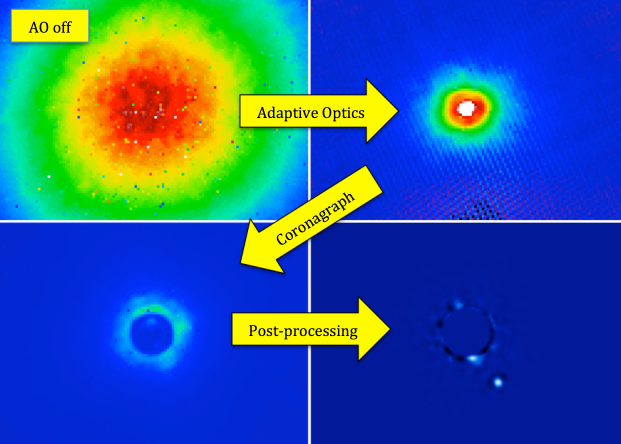

In [4]:
print('Image credit: C. Marois')
Image.open('figures_tutorial/schematic.jpg').reduce(3)

## VAMPIRES H$\alpha$ / H$\alpha$_cont simultaneous imaging
## We will implement angular differential imaging (ADI) and spectral differential imaging (SDI)
### The new H$\alpha$ filter is replaced in January 2020

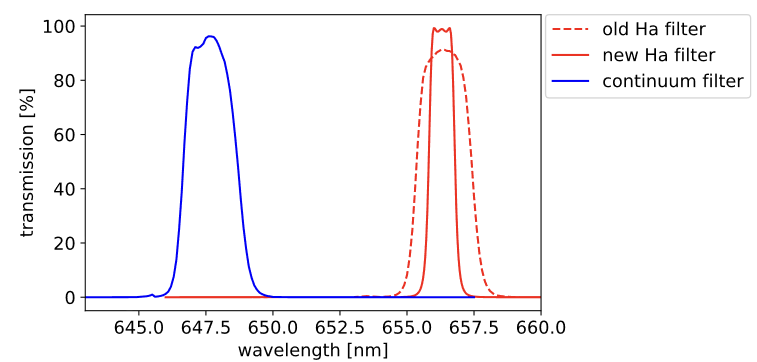

In [5]:
Image.open('figures_tutorial/VAMP_filters.png').reduce(2)

## Conlusion: We will obtain high-contrast H$\alpha$ and H$\alpha$_cont images via ADI, then apply SDI (if we expect to detect something only at Ha)

# 1) calibrating the raw data
## let's get started on handling actual VAMPIRES data.
## $\circ$Target: AB Aur (DO NOT SHARE OUTSIDE!!)
## $\circ$Obs date: Nov 22, 2024 UT
## $\circ$Configuration: Ha/Ha_cont PDI
### - we will not reduce PDI, but simply combine polarimetric images into total intensity this time.

## a) sort data

In [6]:
! yes N | dpp sort tutorial_raw/*fits -o sorted/ -c 

Sorting files: 100%|██████████████████████████| 442/442 [00:28<00:00, 15.38it/s]
yes: stdout: Broken pipe


### note: ignore the broken pipe message. -c means making copies (leave the raw files in the original directory). if you don't need to copy use -nc option instead.
### you see './sorted' directory after frame sorting

## b) create calibration files

In [7]:
! dpp calib -o master_cals back sorted/darks/*/*fits

Collapsing background frames: 100%|███████████████| 8/8 [01:34<00:00, 11.81s/it]


### you see './master_cals' directory where the calibration files are stored

## c) prepare the configurations ('dpp new' works only on command-line interface)

In [6]:
from vampires_dpp.pipeline import config
from astroquery.simbad import Simbad
Simbad.add_votable_fields('V','RA','Dec','pmra','pmdec','parallax','sp_type')
from astropy.coordinates import SkyCoord
import astropy.units as u

target_name = 'AB_Aur'

## extract AB Aur information from Simbad

In [7]:
simbad_result = Simbad.query_object(target_name)
c = SkyCoord(ra=simbad_result['ra'][0]*u.deg,dec=simbad_result['dec'][0]*u.deg)
ra = c.ra.to_string(unit=u.hour, sep=':',precision=2)
dec = c.dec.to_string(unit=u.deg, sep=':',precision=2)
pmra = simbad_result['pmra'][0]
pmdec = simbad_result['pmdec'][0]
parallax = simbad_result['plx_value'][0]
sptype = simbad_result['sp_type'][0]
if len(sptype)>3:
    sptype=sptype[0:3]
Vmag = simbad_result['V'][0]

## prepare the configuration file

In [8]:
cfg = config.PipelineConfig
target = config.TargetConfig(name=target_name,ra=ra,dec=dec,pm_ra=pmra,pm_dec=pmdec,parallax=parallax)

config_ABAur = cfg(name=target_name,target=target)
config_ABAur.calibrate.calib_directory='master_cals/'
config_ABAur.save_adi_cubes=True

### if you want to do frame selection, change to True ###
config_ABAur.frame_select.frame_select=False
config_ABAur.frame_select.metric='strehl'
config_ABAur.frame_select.cutoff=0.0
config_ABAur.frame_select.save_intermediate=False
#########################
config_ABAur.specphot.unit='Jy/arcsec^2'
config_ABAur.specphot.sptype=sptype
config_ABAur.specphot.mag=Vmag
config_ABAur.specphot.mag_band='V'

config_ABAur.save('./'+target_name+'.toml')

### if you want to reduce pdi, set 'diff_images' and 'polarimetry' keywords
### https://scexao-org.github.io/vampires_dpp/configuration.html#id2

## d) Prepare image centroids estimates

## you need to run 'dpp centroid' for each filter data because this data set is Ha-SDI+PDI that is not fully supported by the current DPP version
## also make different output directories

### note: if you're calibrating MBI (non-SDI) data, you can simply follow the instruction of VAMPIRES DPP, no need to separately run 'dpp centroid' and 'dpp run'

### d-1) Ha data

In [18]:
! dpp centroid AB_Aur.toml -np sorted/ABAUR/Open_Halpha_000200102us_536x536/*fits -o Ha

Parsing FITS headers: 100%|███████████████████| 217/217 [00:05<00:00, 42.56it/s]
[10:49:53.825] Creating mean frame from 10 files
[10:49:57.337] Saved raw PSF frame to Ha/aux/AB_Aur_mean_image_cam1.fits
[10:49:57.340] Creating mean frame from 10 files
[10:50:00.701] Saved raw PSF frame to Ha/aux/AB_Aur_mean_image_cam2.fits
[10:50:00.709] Making synthetic PSF for Halpha
[10:50:01.113] Making synthetic PSF for Halpha
[10:50:01.447] Saved cam1 centroids to Ha/aux/AB_Aur_centroids_cam1.toml
[10:50:01.447] Saved cam2 centroids to Ha/aux/AB_Aur_centroids_cam2.toml


### d-2) Ha-cont data

In [19]:
! dpp centroid AB_Aur.toml -np sorted/ABAUR/Open_Ha-Cont_000200102us_536x536/*fits -o Ha-cont

Parsing FITS headers: 100%|███████████████████| 217/217 [00:05<00:00, 39.57it/s]
[10:50:10.634] Creating mean frame from 10 files
[10:50:14.764] Saved raw PSF frame to Ha-cont/aux/AB_Aur_mean_image_cam1.fits
[10:50:14.767] Creating mean frame from 10 files
[10:50:18.180] Saved raw PSF frame to Ha-cont/aux/AB_Aur_mean_image_cam2.fits
[10:50:18.187] Making synthetic PSF for Ha-Cont
[10:50:18.574] Making synthetic PSF for Ha-Cont
[10:50:18.922] Saved cam1 centroids to Ha-cont/aux/AB_Aur_centroids_cam1.toml
[10:50:18.922] Saved cam2 centroids to Ha-cont/aux/AB_Aur_centroids_cam2.toml


## e) run the main function of VAMPIRES DPP with the configuration file
### see the DPP tutorial for the processing steps (can be modified in the config file)
### https://scexao-org.github.io/vampires_dpp/quickstart.html#running-the-pipeline

### e-1) Ha data

In [9]:
! dpp run AB_Aur.toml sorted/ABAUR/Open_Halpha_000200102us_536x536/*fits -o Ha

[01:23:26.685] VAMPIRES DPP: v0.14.1
[01:23:26.687] Using 1 processes
[01:23:26.688] Note: a detailed log can be found in Ha/debug.log
[01:23:26.688] Tip: watch it live with `tail -f Ha/debug.log`
[01:23:32.597] Saved input header table to: Ha/aux/AB_Aur_input_headers.csv
[01:23:33.058] Saved file combination table to /Volumes/data_astro/analysis_VAMPIRES/tutorial/Ha/aux/AB_Aur_file_combinations.csv
Processing files: 100%|███████████████████████| 217/217 [03:15<00:00,  1.11it/s]
[01:26:54.467] Creating table from output headers
[01:27:02.681] Saved output header table to Ha/aux/AB_Aur_table.csv
[01:27:02.693] Stacking output files into ADI cubes
Loading and combining both cams: 100%|████████| 217/217 [00:18<00:00, 11.54it/s]
[01:27:23.821] Saved ADI cube to Ha/adi/AB_Aur_adi_cube.fits
[01:27:23.890] Finished processing files


### e-2) Ha-cont data

In [11]:
! dpp run AB_Aur.toml sorted/ABAUR/Open_Ha-Cont_000200102us_536x536/*fits -o Ha-cont

[01:29:39.728] VAMPIRES DPP: v0.14.1
[01:29:39.729] Using 1 processes
[01:29:39.729] Note: a detailed log can be found in Ha-cont/debug.log
[01:29:39.730] Tip: watch it live with `tail -f Ha-cont/debug.log`
[01:29:45.277] Saved input header table to: Ha-cont/aux/AB_Aur_input_headers.csv
[01:29:45.296] Making synthetic PSF for Ha-Cont
[01:29:45.525] Saving synthetic PSF to Ha-cont/aux/VAMPIRES_Ha-Cont_synthpsf.fits
[01:29:45.597] Saved file combination table to /Volumes/data_astro/analysis_VAMPIRES/tutorial/Ha-cont/aux/AB_Aur_file_combinations.csv
Processing files: 100%|███████████████████████| 217/217 [03:03<00:00,  1.18it/s]
[01:32:56.670] Creating table from output headers
[01:33:04.162] Saved output header table to Ha-cont/aux/AB_Aur_table.csv
[01:33:04.170] Stacking output files into ADI cubes
Loading and combining both cams: 100%|████████| 217/217 [00:19<00:00, 11.16it/s]
[01:33:25.814] Saved ADI cube to Ha-cont/adi/AB_Aur_adi_cube.fits
[01:33:25.877] Finished processing files


# let's see what you got after dpp run
### i.e. registed sets of the calibrated frames, and the list of the parallactic angle

In [16]:
! ls Ha/adi/*fits
! ls Ha-cont/adi/*fits

Ha/adi/AB_Aur_adi_angles.fits Ha/adi/AB_Aur_adi_cube.fits
Ha-cont/adi/AB_Aur_adi_angles.fits Ha-cont/adi/AB_Aur_adi_cube.fits


# display the Ha output

In [7]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np

### the first frame of the data

the number of the frames: 217


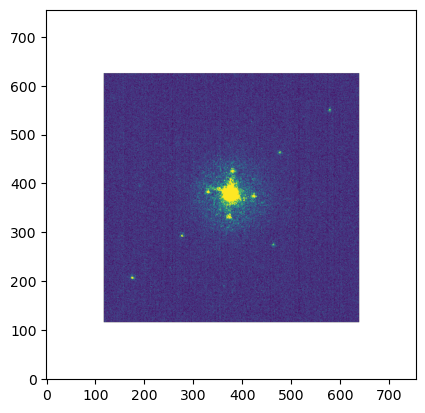

In [18]:
Ha_datalist = fits.getdata('Ha/adi/AB_Aur_adi_cube.fits')
print(f'the number of the frames: {len(Ha_datalist)}')
plt.imshow(Ha_datalist[0][0],vmin=np.nanpercentile(Ha_datalist[0][0],0.5),vmax=np.nanpercentile(Ha_datalist[0][0],99.5),origin='lower')

### the list of the parallactic angle'

rotation angle: 23.001487731933594 deg


Text(0, 0.5, 'parallctic angle [deg]')

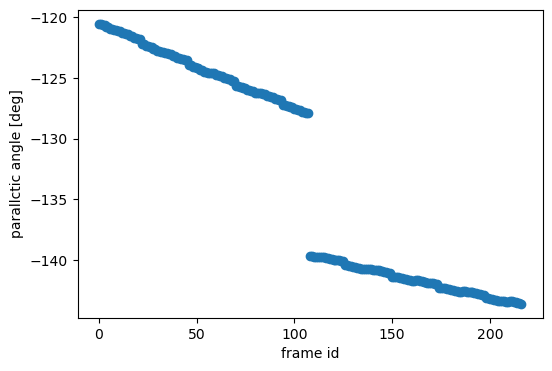

In [25]:
anglist = fits.getdata('Ha/adi/AB_Aur_adi_angles.fits')
print(f'rotation angle: {abs(anglist[-1]-anglist[0])} deg')

plt.figure(figsize=(6,4))
plt.scatter(range(len(anglist)),anglist)
plt.xlabel('frame id')
plt.ylabel('parallctic angle [deg]')

## now you finished the first calibration step using VAMP DPP, and these files are input files for post-processing

# 2) post-processing with pyklip